# Introduction to vector and raster data manipulation with `geopandas` and `rasterio`

This section will borrow heavily from the NCEAS/Arctic Data Center [workshop material](https://learning.nceas.ucsb.edu/2022-09-arctic/sections/10-geopandas.html)!

Let's go exploring on the Arctic Data Center's [catalog](https://arcticdata.io/catalog/data)! I searched for `.tif` files and found a dataset from Berner, L.T., P. Jantz, K.D. Tape, and S.J. Goetz. 2018. Tundra plant above-ground biomass and shrub dominance mapped across the North Slope of Alaska. Environmental Research Letters. 13(3):035002. https://doi.org/10.1088/1748-9326/aaaa9a

In [49]:

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import numpy.ma as ma # numpy mask module
import urllib

In [50]:
# pip install rasterio
import rasterio

# Part 1: Raster data

Below, we are going to pull data directly off of the Arctic Data Center's repository. The URL is for the data entry, which is the first argument in  `urlretrieve`, and the second argument is the specific file to be downloaded

In [51]:
url = 'https://cn.dataone.org/cn/v2/resolve/urn:uuid:8233336b-0b1c-4809-b01e-4786f26db63a'

msg = urllib.request.urlretrieve(url, "shrub_dominance_of_agb_p50.tif")

Let's take a look at the `.tif` we just downloaded

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 35405, 'height': 14890, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(30.0, 0.0, -540475.274307,
       0.0, -30.0, 2380628.0574), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


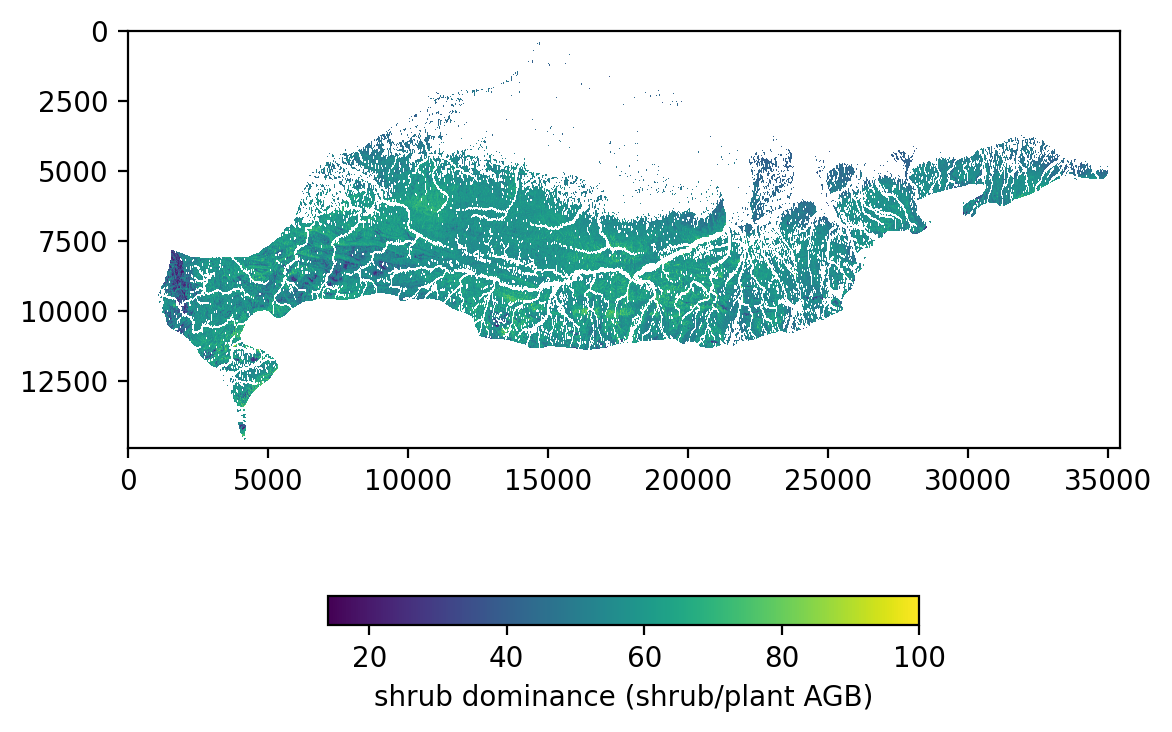

In [52]:
fig, ax = plt.subplots(dpi=200)
with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:
    # read in raster (1st band)
    shrub_arr = shrub_dom.read(1)
    shrub_arr = ma.masked_where(shrub_arr == shrub_dom.nodata, shrub_arr)
    # shrub_arr = shrub_arr
    shrub_meta = shrub_dom.profile

im0 = ax.imshow(shrub_arr)
cb = fig.colorbar(im0, ax=ax, label="shrub dominance (shrub/plant AGB)",  orientation='horizontal', fraction=0.04, pad=0.2)
print(shrub_meta)

What's going on here?
- we instantiated a `fig` and `ax` object
- we used `numpy.ma` to mask out the nodata values (which are 255.0)
- we printed out the metadata for the raster
- we used `imshow()` on the `ax` object to display the values of the array 
- the axes have an origin at the bottom left of (0,0) because we did not provide `imshow` an `extent`, which we will see later, that can put the x and y axes in real space

FWIW I think there is maybe some issue here, I feel like there should be more data than the nodata mask implies...whatever, go check out the [original work](https://iopscience.iop.org/article/10.1088/1748-9326/aaaa9a)

# Part 2: vector data

Next let's look at vector data. I have already downloaded for you the Circum-Arctic permafrost extent map from the NSIDC [here](https://nsidc.org/data/ggd318/versions/2)

<Axes: >

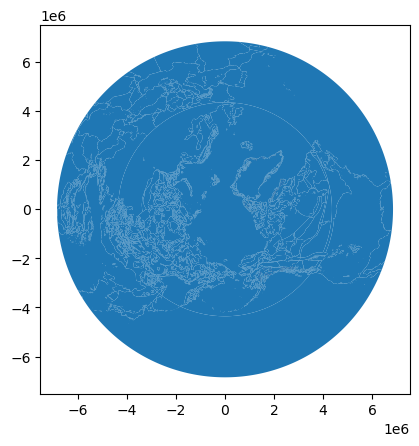

In [53]:
permafrost = gpd.read_file("../arctic-data/permaice.shp")

permafrost.plot()

Let's transform this to the [coordinate reference system](https://geopandas.org/en/stable/docs/user_guide/projections.html) that our raster is in 

<Axes: >

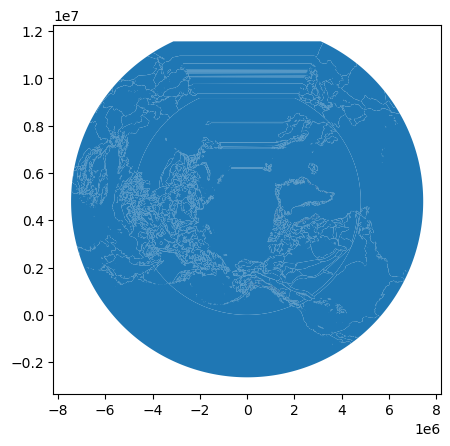

In [54]:
permafrost = permafrost.to_crs("EPSG:3338")

permafrost.plot()

You'll see that geopandas is pretty good at reprojecting, but man are conical polar projections tricky math! If you go right to pseudo-Mercator from a polar projection, you'll smear these shapefiles across the Arctic. Instead, let's clip the permafrost shapefile to the extent of our shrub dominance raster

<Axes: >

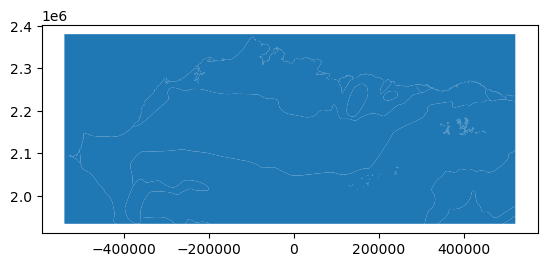

In [79]:
with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:
    # Use Shapely to make a box geodataframe object from the bounds of the raster
    bbox = box(shrub_dom.bounds[0], shrub_dom.bounds[1], shrub_dom.bounds[2], shrub_dom.bounds[3])
    coord_box_df = gpd.GeoDataFrame(crs = 'EPSG:3338',geometry = [bbox])

# ...and then clip to it!

permafrost_clip = permafrost.clip(coord_box_df)

permafrost_clip.plot()

OK, but this blue is boring. What is even in this object anyway?

In [80]:
permafrost_clip.head()

,NUM_CODE,COMBO,RELICT,EXTENT,CONTENT,LANDFORM,geometry
9137,10,Dlf,NaN,D,l,f,"POLYGON ((341138.818 1936086.632, 343711.235 1..."
9317,21,g,NaN,NaN,NaN,NaN,"POLYGON ((200217.232 2042337.118, 199576.779 2..."
9319,21,g,NaN,NaN,NaN,NaN,"POLYGON ((186593.887 2048343.367, 186855.045 2..."
9318,21,g,NaN,NaN,NaN,NaN,"POLYGON ((184624.861 2047429.837, 183834.461 2..."
9585,1,Chf,NaN,C,h,NaN,"POLYGON ((-254260.311 1936391.307, -252547.019..."


That's right, geopandas GeoDataFrames are just dataframes with some spatial info! We can look at the columns to see attributes for the shapefiles. "COMBO" is the three letter combination of permafrost extent, ice content, and overburden (soil) thickness. Read the user manual [here](https://nsidc.org/sites/default/files/ggd318-v002-userguide.pdf)

<Axes: >

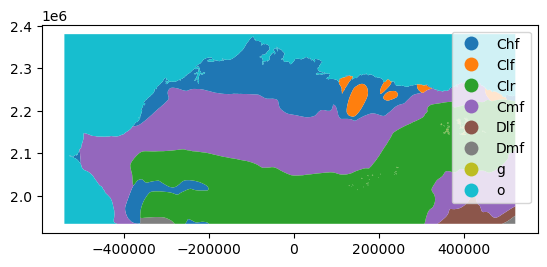

In [57]:
permafrost_clip.plot(column="COMBO", legend=True)

# Part 3: together!

`rasterio.plot.show(src)` can plot raster data. But rasters are just grids (or arrays) of numbers. If you tell `plt.imshow()` the extent (boundaries) of the image (the data array), you can transform your raster data however you want, and you can plot it with vector data as well. 

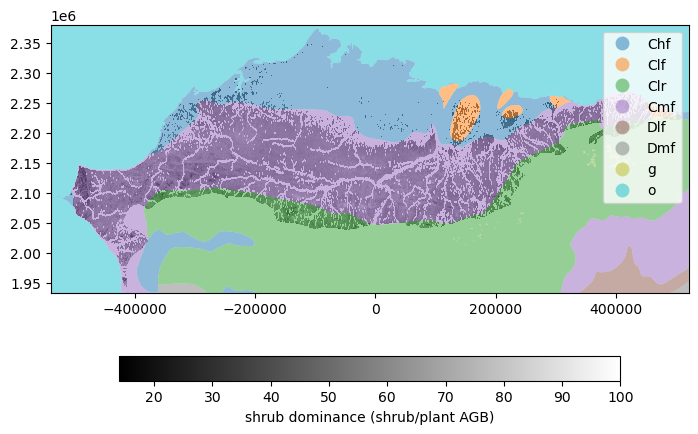

In [58]:
fig, ax = plt.subplots(figsize=(7, 7))
with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:
    shrub_arr = shrub_dom.read(1)
    shrub_arr = ma.masked_where(shrub_arr == shrub_dom.nodata, shrub_arr)
    # Don't you love how "extent" coordinates need to be in a different order? :upside-down smiley face:
    extent=[shrub_dom.bounds[0], shrub_dom.bounds[2], shrub_dom.bounds[1], shrub_dom.bounds[3]]
    im0 = ax.imshow(shrub_arr,
    extent=extent,
    # vmin=0.0,
    # vmax=1.0,
    cmap="binary_r",
    zorder=0,
    )

    shape = permafrost_clip.plot(column="COMBO", legend=True, alpha=0.5, zorder=2, ax=ax)

cb = fig.colorbar(im0, ax=ax, label="shrub dominance (shrub/plant AGB)",  orientation='horizontal', fraction=0.04, pad=0.1)

fig.tight_layout()
# Note I am being a bad data visualizer because white is both 100 and nodata. 

# Part 4: Split-apply-combine raster data with vector data

What if we wanted to analyze raster data grouped by vector data properties? The strategy we have here is to [`rasterize`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize) our vector data - instead of having polygons with certain properties, we're going to create arrays where there is one value "under" the polygon of interest and another value (0, or null) everywhere else

First we get the necessary data and metadata from our raster of interest

In [ ]:

from rasterio import features

with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:

    shrub_meta = shrub_dom.profile
    shrub_arr = shrub_dom.read(1)
    shrub_arr = ma.masked_where(shrub_arr == shrub_dom.nodata, shrub_arr)


Now is a great time to [`dissolve`](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) our polygons based on their `COMBO` values so that we are rasterizing all the values we are interested in at once

In [81]:
permafrost_clip = permafrost_clip.dissolve(by='COMBO').reset_index()
# resetting the index helps us iterate through the geometries in the next step, though note each NUM_CODE is unique to the COMBO
permafrost_clip

,COMBO,geometry,NUM_CODE,RELICT,EXTENT,CONTENT,LANDFORM
0,Chf,"MULTIPOLYGON (((-247128.366 1945123.974, -2443...",1,None,C,h,None
1,Clf,"MULTIPOLYGON (((149292.655 2259233.087, 150336...",9,None,C,l,f
2,Clr,"MULTIPOLYGON (((512181.379 2223977.145, 517526...",17,None,C,l,r
3,Cmf,"MULTIPOLYGON (((514818.928 1971589.998, 509636...",5,None,C,m,f
4,Dlf,"POLYGON ((341138.818 1936086.632, 343711.235 1...",10,None,D,l,f
5,Dmf,"MULTIPOLYGON (((-350354.560 1948287.683, -3418...",6,None,D,m,f
6,g,"MULTIPOLYGON (((150906.314 2015254.461, 151164...",21,None,None,None,None
7,o,"MULTIPOLYGON (((-363835.227 1934721.562, -3629...",24,None,None,None,None


Now we're going to instantiate two [dictionaries](https://docs.python.org/3/tutorial/datastructures.html) to store the resulting data arrays. Joanmarie will elaborate in the workshop but basically you don't want to store lists or arrays in pandas dataframes. Your goal is to store big raw datasets in dictionaries, reduce them, and then stick them back into your dataframe when all is said and done. 

In [84]:
means_dict = {}
raw_values_dict = {}

And now we shall (1) rasterize our polygons, (2) make a mask over the raster where the polygon value is present, and both (3) store that raw masked array and (4) calculate the mean of that masked array

In [105]:
for geom, idx in zip(permafrost_clip['geometry'], permafrost_clip.index):
    # I spent WAY too much time messing around with this part, you apparently can't just
    # give rasterize a polygon, it has to either be a MutliPolygon or a list of geometries
    # This code does the latter, and the Arctic Data Center tutorial's only works because their
    # example vector data is accidentally multipolygons, but our data has a polygon
    geom = shape(geom)
    geoms = [(geom, 1)]
    # Now this looks like the ADC example
    rasterized = features.rasterize(
                                    geoms,
                                    out_shape=shrub_arr.shape, # Look like the source raster
                                    transform=shrub_meta['transform'], # Have the geometry of the source raster
                                    all_touched=True # all pixels touched by geometries (as opposed to pixel centers)
                                    )
    # Theoretically instead of individually rasterizing each polygon type
    # You could rasterize the whole thing and instead of 0s and 1s you can
    # make the raster value the index and then do basic array-style analyses
    # Maybe I can offer treats to someone who writes that for me...
    r_index = np.where(rasterized == 1) # Make the mask
    # r_index.filled(np.nan)
    raw_values_dict[idx] = shrub_arr[r_index].compressed() # store all non-masked data (the compressed thing)
    means_dict[idx] = np.nanmean(shrub_arr[r_index].compressed()) # calculate the mean of the data

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/d

Now we have a dictionary whose keys are the index and the values are the means of the masked arrays

In [106]:
means_dict

{0: 44.39353379745159,
 1: 42.631778884652284,
 2: 55.83465172241535,
 3: 56.71177123132905,
 4: nan,
 5: nan,
 6: nan,
 7: 43.095048284069485}

*Whenever I say "masked array" I always think of:*

![masquerade](https://media.tenor.com/FTk5tv3gF9MAAAAC/musical-phantom-of-the-opera.gif "masquerade")


But I also made a dictionary that stored *all* of the values:

In [104]:
raw_values_dict

{0: array([20, 18, 29, ..., 66, 63, 74], dtype=uint8),
 1: array([32, 31, 35, ..., 44, 44, 43], dtype=uint8),
 2: array([61, 59, 58, ..., 54, 52, 51], dtype=uint8),
 3: array([44, 44, 38, ..., 46, 45, 42], dtype=uint8),
 4: array([], dtype=uint8),
 5: array([], dtype=uint8),
 6: array([], dtype=uint8),
 7: array([31, 42, 39, ..., 43, 28, 34], dtype=uint8)}

Maybe you want to do further analyses on the data that you don't want to reduce in that loop. For example, maybe you want to set a threshold number of pixels before you allow for a mean to be counted? This is relevant in this example where the polygon for "ocean" has some data in it.

In [114]:
# len is length of the array, or number of unmasked pixels 
{key: len(value) for key, value in raw_values_dict.items()}

{0: 36246653,
 1: 4599337,
 2: 15237788,
 3: 113458088,
 4: 0,
 5: 0,
 6: 0,
 7: 278974}

Now we just create a data frame from that dictionary, and join it to the vector data using `pandas` operations.

In [108]:
import pandas as pd
# create a data frame from the result
means_df = pd.DataFrame.from_dict(means_dict,
                                     orient='index',
                                     columns=['mean_shrub'])

In [109]:
means_df

,mean_shrub
0,44.393534
1,42.631779
2,55.834652
3,56.711771
4,NaN
5,NaN
6,NaN
7,43.095048


[`pd.DataFrame.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) is a common and powerful way to join two dataframes that share common columns or indices (the latter is true in our case)

In [110]:
perma_data = permafrost_clip.merge(means_df,
                                    left_index=True,
                                    right_index=True,
                                    how='inner')

perma_data

,COMBO,geometry,NUM_CODE,RELICT,EXTENT,CONTENT,LANDFORM,mean_shrub
0,Chf,"MULTIPOLYGON (((-247128.366 1945123.974, -2443...",1,None,C,h,None,44.393534
1,Clf,"MULTIPOLYGON (((149292.655 2259233.087, 150336...",9,None,C,l,f,42.631779
2,Clr,"MULTIPOLYGON (((512181.379 2223977.145, 517526...",17,None,C,l,r,55.834652
3,Cmf,"MULTIPOLYGON (((514818.928 1971589.998, 509636...",5,None,C,m,f,56.711771
4,Dlf,"POLYGON ((341138.818 1936086.632, 343711.235 1...",10,None,D,l,f,NaN
5,Dmf,"MULTIPOLYGON (((-350354.560 1948287.683, -3418...",6,None,D,m,f,NaN
6,g,"MULTIPOLYGON (((150906.314 2015254.461, 151164...",21,None,None,None,None,NaN
7,o,"MULTIPOLYGON (((-363835.227 1934721.562, -3629...",24,None,None,None,None,43.095048


Now make a map! I took some inspiration for treating missing data from the [GeoPandas docs](https://geopandas.org/en/stable/docs/user_guide/mapping.html):

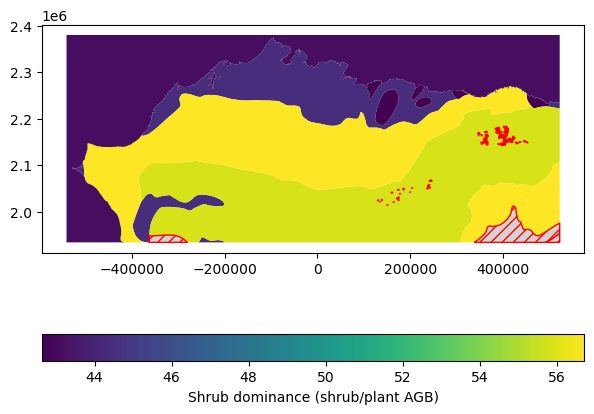

In [112]:
fig, ax = plt.subplots(figsize=(7, 7))
res = perma_data.plot(column="mean_shrub",
                        legend=True,
                        legend_kwds={'label': "Shrub dominance (shrub/plant AGB)",
                        'orientation': "horizontal"},
                        missing_kwds={
                        "color": "lightgrey",
                        "edgecolor": "red",
                        "hatch": "///",
                        "label": "No values",
                        },
                        ax=ax
                        )

So yeah, maybe you'd write a lil script that turns data into NaNs if the threshold is below a certain number...or you just decide to go in and get rid of the data in the ocean. :shrug:
Of course this analysis is a little meaningless as the polygons are huge, but you can see how this would work!

Another option is to just install and use [`rasterstats`](https://github.com/perrygeo/python-rasterstats/tree/d188eaf1f1c20c3ef33aad407f55f9fce51a1220), whose source code I have stolen to write the above snippets

# A note: point data

So, you can use `rasterio` and `geopandas` to [sample](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) point data. A good example can be found in the [GeoPandas docs](https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html). If you want to sample an area around a point, consider employing a [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html).

# Hackathon prompt:

Between the Arctic Data Center, the [National Snow and Ice Data Center](https://nsidc.org/home), the [Arctic Permafrost Geospatial Centre](https://apgc.awi.de/), and others, there are so many vector and raster datasets to cross-analyze! Go do some science. 